In [1]:
%load_ext autoreload
%autoreload 2
import torch
import eq
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm

In [2]:
print(eq.data.default_catalogs_dir)

/home/zekai/repos/recast/data


In [8]:
catalog = eq.catalogs.ANSS_MultiCatalog(num_sequences=10000,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,)

Generating the catalog...
Downloading...
train


100%|██████████| 6000/6000 [00:08<00:00, 672.15it/s]


val


100%|██████████| 2000/2000 [00:02<00:00, 807.45it/s]


test


100%|██████████| 2000/2000 [00:02<00:00, 838.64it/s]


Success!
Catalog saved to /home/zekai/repos/recast/data/ANSS_MultiCatalog


In [9]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [3845],
  arrival_times: [3844],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [3844],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Validation sequence:
Sequence(
  inter_times: [475],
  arrival_times: [474],
  t_start: 0.0,
  t_end: 836.746,
  t_nll_start: 0.0,
  mag: [474],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Test sequence:
Sequence(
  inter_times: [460],
  arrival_times: [459],
  t_start: 0.0,
  t_end: 1460.0,
  t_nll_start: 0.0,
  mag: [459],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)


<Axes: xlabel='Time (days)', ylabel='Magnitude'>

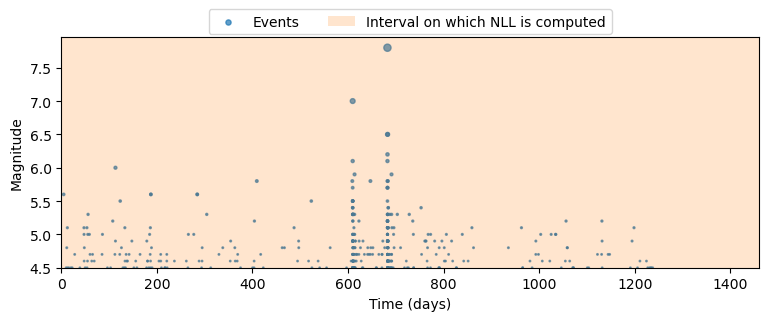

In [10]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

In [11]:
dl_train = catalog.train.get_dataloader(batch_size=1)
dl_val = catalog.val.get_dataloader(batch_size=1)
dl_test = catalog.test.get_dataloader(batch_size=1)

In [13]:
!gpustat
gpu_number = 0
device = torch.device(f"cuda:{gpu_number}")
print(f"using {device}")

zekai-MS-7E07               Thu Nov  2 12:16:31 2023  535.113.01
[0] NVIDIA GeForce RTX 4090 | 49'C,   4 % |  1479 / 24564 MB | zekai(563M) zekai(154M) zekai(103M) zekai(289M)
using cuda:0


In [14]:
model = eq.models.ETAS()
model = model.to(device)

In [15]:
epochs = 100
avg_train_loss_list =[]
avg_val_loss_list = []

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

for epoch in trange(epochs):
    running_training_loss = []
    model.train()
    for i, data in enumerate(dl_train):
        data = data.to(device)
        optimizer.zero_grad()
        nll = model.nll_loss(data).mean()
        nll.backward()
        optimizer.step()
        running_training_loss.append(nll.item())
    
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        for i, data in enumerate(dl_val):
            data = data.to(device)
            nll = model.nll_loss(data).mean()
            running_val_loss.append(nll.item())

    avg_train_loss_list.append(np.mean(running_training_loss))
    avg_val_loss_list.append(np.mean(running_val_loss))

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
model.eval()
with torch.no_grad():
    running_test_loss = []
    for i, data in enumerate(dl_test):
        data = data.to(device)
        nll = model.nll_loss(data).mean()
        running_test_loss.append(nll.item())
print(f"avg test loss: {np.mean(running_test_loss)}")

avg test loss: 0.4344967265033483


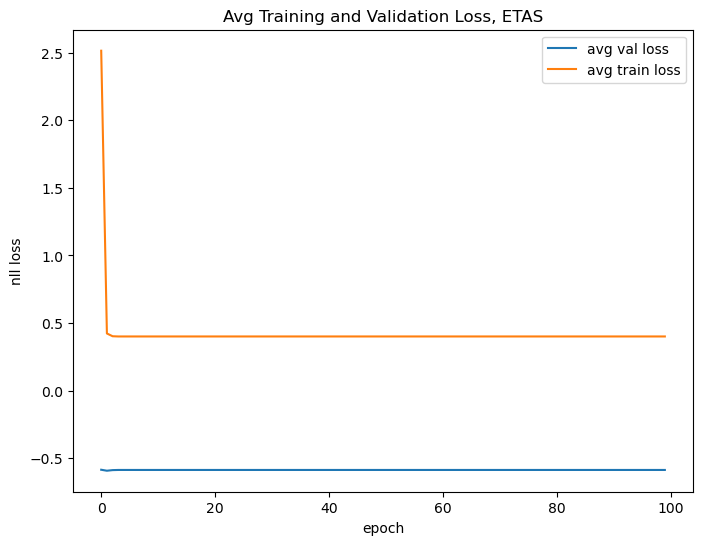

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(0, epochs), avg_val_loss_list, label="avg val loss")
ax.plot(np.arange(0, epochs), avg_train_loss_list, label="avg train loss")
ax.set_xlabel("epoch")
ax.set_ylabel("nll loss")
ax.legend()
ax.set_title("Avg Training and Validation Loss, ETAS")
plt.show()

In [21]:
torch.save(model, "/home/zekai/repos/recast/notebooks/Zekai/trained_etas")

ETAS()